In [1]:
#Importing packages
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
import random as rn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
import datetime
import glob
import warnings
from tensorflow.keras import models, layers
from sklearn.metrics import cohen_kappa_score
import math
from keras.regularizers import l1 ,l2
import keras
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

import argparse
from google.colab import files
import os
import warnings

from keras.callbacks import Callback
from keras import backend as K
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Custom method -  to fetch the actual path & name of all the images
def abs_path(imgs):
    img_path = list()
    img_fullname = list()
    img_name = list()
    for i in imgs:
        img_path.append(i)
        temp = i.split("/")[-1]
        img_fullname.append(temp)
        temp = temp.split(".")[0]
        img_name.append(str(temp))
    return img_path, img_fullname, img_name

In [ ]:
images = glob.glob('/content/drive/MyDrive/Colab_Notebooks/Case_study2/preprocessed/*')
img_path, img_fullname, img_name = abs_path(images)

In [ ]:
pre_df = pd.DataFrame()
pre_df['path'] = img_path
pre_df['fullname'] = img_fullname
pre_df['id_code'] = img_name

In [ ]:
# Reading DR grades files of 2019, Messidor & IDRiD
train2019 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/train.csv')
train2019 = train2019[['id_code', 'diagnosis']]
messidor = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/messidor_data.csv')
messidor = messidor[['id_code', 'diagnosis']]
idridtrain = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/IDRID_Training_Labels.csv')
idridtrain = idridtrain[['id_code', 'diagnosis']]
idridtest = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/IDRID_Testing_Labels.csv')
idridtest = idridtest[['id_code', 'diagnosis']]

In [ ]:
# Fetching DR grades of the respective images of 2019, IDRiD & Messidor data
labels = list()
id_code = list()
for i, j in train2019.iterrows():
    id_code.append(j['id_code'])
    labels.append(j['diagnosis'])

for i, j in messidor.iterrows():
    id_code.append(j['id_code'].split(".")[0])
    labels.append(j['diagnosis'])

for i, j in idridtrain.iterrows():
    id_code.append(j['id_code'])
    labels.append(j['diagnosis'])

for i, j in idridtest.iterrows():
    id_code.append(j['id_code'])
    labels.append(j['diagnosis'])

In [ ]:
train_labels = pd.DataFrame() # Storing the image file name & DR grades into the dataframe
train_labels['id_code'] = id_code
train_labels['diagnosis'] = labels

In [ ]:
# Merging the image path & DR grades 
pre_df = pd.merge(pre_df, train_labels, on='id_code', how='left')

In [ ]:
pre_df = pre_df[pre_df['diagnosis'].notna()] # removing row if the DR grade is NaN

In [ ]:
print(pre_df[pre_df['diagnosis'].isnull()]) # Verify if there is any NaN present in the DR grades field

Empty DataFrame
Columns: [path, fullname, id_code, diagnosis]
Index: []


In [ ]:
dia_code = list()   # Converting the data type of DR grades field from Float to Int
for i, j in pre_df.iterrows():
    dia_code.append(int(j['diagnosis']))

In [ ]:
del pre_df['diagnosis'] # removing the existing DR grades field with data type as Float

In [ ]:
pre_df['diagnosis'] = dia_code # adding DR grades with data type as Int

In [ ]:
pre_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/preprocessed_images.csv')

In [3]:
pre_df=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/preprocessed_images.csv',dtype=str)

**Train and test data split up** 

In [4]:
# train test split
from sklearn.model_selection import train_test_split
y = pre_df['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(pre_df, y, test_size=0.20, stratify=y)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4188, 4)
(1047, 4)
(4188,)
(1047,)


**1. VGG Model**

* Use VGG-16 pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights.
* After VGG-16 network without FC layers, use conv layers only as Fully connected layer. Reference - https://cs231n.github.io/convolutional-networks/#convert
* Final architecture will be VGG-16 without FC layers(without top), 2 Conv layers identical to FC layers, 1 output layer for 5 class classification. INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer
* Train only last 2 Conv layers identical to FC layers, 1 output layer.

**1.1 Image Augumentation**

In [ ]:
# reference URL - https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
from keras_preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255., validation_split=0.20, rotation_range=15, fill_mode='nearest', width_shift_range=0.1, height_shift_range=0.1, 
                horizontal_flip=True, vertical_flip=True)

train_generator=datagen.flow_from_dataframe(dataframe=X_train, directory=None, x_col="path", y_col="diagnosis", subset="training", 
                batch_size=8, seed=10, shuffle=True, class_mode="categorical", drop_duplicates = False, target_size=(320,320))

valid_generator=datagen.flow_from_dataframe(dataframe=X_train, directory=None, x_col="path", y_col="diagnosis", subset="validation", 
                        batch_size=8, seed=10, shuffle=True, class_mode="categorical", drop_duplicates = False, target_size=(320,320))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(dataframe=X_test, directory=None, x_col="path", 
                y_col=None, batch_size=8, seed=10, shuffle=False, class_mode=None, target_size=(320,320))

Found 3351 validated image filenames belonging to 5 classes.
Found 837 validated image filenames belonging to 5 classes.
Found 1047 validated image filenames.


**1.3 Building VGG16 Model**

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(320,320,3))

# Freeze base model
vgg_base.trainable = False

#Input layer
input_layer = Input(shape=(320,320,3))

vgg_layer= vgg_base(input_layer)

#Conv Layer
Conv1 = Conv2D(128, 10, strides=1 , padding = 'valid', activation='relu')(vgg_layer)


#MaxPool Layer
Conv2 = Conv2D(64, 1, strides=1 , padding = 'valid', activation='relu')(Conv1)

flatten = Flatten(data_format='channels_last')(Conv2)
#output layer
outputs = Dense(5,activation='softmax')(flatten)


#Creating a model
vgg_model = Model(inputs=input_layer,outputs=outputs)


#creating object to ReduceLROnPlateau class to decay lr by 10% If validation accuracy is less than previous epoch accuracy(cond1)
reducelrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.96, verbose=1, patience=2, cooldown=2)

#creating object to ModelCheckpoint class to Save model at every epoch if validation accuracy is improved from previous epoch
filepath='/content/w/weights-{epoch:02d}-{accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_accuracy',  verbose=1)

callbacks_list = [reducelrate, checkpoint] #Merging all the callbacks in a list

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy']) #Compiling model with cross-entropy as loss
print(vgg_model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 10, 10, 512)       14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 128)         6553728   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 21,276,997
Trainable params: 6,562,309
Non-trainable params: 14,714,688
_________________________________________

**1.4 Training the VGG16 model**

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
vgg_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID, epochs=40, callbacks=callbacks_list)

Epoch 1/40
392/392 [==============================] - 2702s 7s/step - loss: 1.0720 - accuracy: 0.6042 - val_loss: 0.9942 - val_accuracy: 0.6059

Epoch 00001: val_accuracy improved from -inf to 0.60587, saving model to /content/w/weights-01-0.6042.hdf5
Epoch 2/40
392/392 [==============================] - 86s 219ms/step - loss: 0.9205 - accuracy: 0.6467 - val_loss: 0.9388 - val_accuracy: 0.6531

Epoch 00002: val_accuracy improved from 0.60587 to 0.65306, saving model to /content/w/weights-02-0.6467.hdf5
Epoch 3/40
392/392 [==============================] - 86s 219ms/step - loss: 0.8916 - accuracy: 0.6451 - val_loss: 0.8613 - val_accuracy: 0.6518

Epoch 00003: val_accuracy did not improve from 0.65306
Epoch 4/40
392/392 [==============================] - 86s 219ms/step - loss: 0.8498 - accuracy: 0.6687 - val_loss: 0.9760 - val_accuracy: 0.6237

Epoch 00004: val_accuracy did not improve from 0.65306
Epoch 5/40
392/392 [==============================] - 86s 219ms/step - loss: 0.8206 - accu

**1.5 Prediction on Test images**

In [ ]:
# Generate predictions
vgg_model.load_weights('/content/w/weights-22-0.7482.hdf5') 

y_pred = vgg_model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)

**1.6 Calculating Quadratic cohen kappa score**

In [ ]:
cohen = cohen_kappa_score(y_pred_class, y_test.astype('int'), weights='quadratic')
print("Quadratic Cohen kappa score of VGG model on test data is - %.3f" %cohen)

Quadratic Cohen kappa score of VGG model on test data is - 0.793


**1.7 Calculating Accuracy & Macro F1 score on test data**

Classification Report : 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       610
           1       0.50      0.21      0.30       151
           2       0.61      0.75      0.67       364
           3       0.45      0.43      0.44        89
           4       0.59      0.25      0.35        95

    accuracy                           0.72      1309
   macro avg       0.60      0.52      0.53      1309
weighted avg       0.70      0.72      0.69      1309



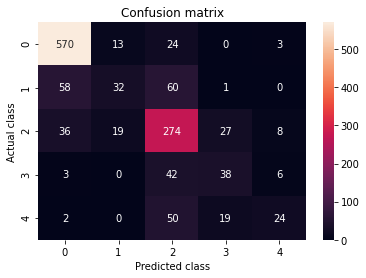

In [ ]:
print ('Classification Report : \n', classification_report(y_test.astype('int'), y_pred_class))
sns.heatmap(confusion_matrix(y_test.astype('int'), y_pred_class), annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

**2. DenseNet Model**

* It connects each layer to every other layer in a feed-forward fashion
* Each CNN layers with L layers have L connections - one between each layer and its subsequent layers
* For each layer, the feature maps of all preceding layers are used as inputs into all subsequent layers.

**2.1 Setting up hyper-parameters**

In [203]:
# Hyperparameters
batch_size = 8
num_classes = 5
l = 14
num_filter = 32
compression = 0.5
dropout_rate = 0

In [204]:
img_height = 32
img_width = 32
channel = 3

**2.2 Defining Dense, Transition & Output block of the DenseNet model** 

In [208]:
tf.keras.backend.clear_session()
# Dense Block
def denseblock(input, num_filter, dropout_rate):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

**2.3 Architecure of the DenseNet model**

In [209]:
num_filter = 32
dropout_rate = 0
l = 14

tf.keras.backend.clear_session()
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(24, (2,2), use_bias=False ,padding='same', kernel_initializer='he_uniform', bias_initializer='zeros',kernel_regularizer=l2(0.0001))(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition, num_filter, dropout_rate)
output = output_layer(Last_Block)

In [210]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

**2.4 Defining the optimizers and compiling the model**

In [211]:
# determine Loss function and Optimizer
tf.keras.backend.clear_session()
#optimizer = SGD(learning_rate=0.1, momentum=0.9, decay= 1e-6, nesterov=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

**2.5 Image augumentation**

In [198]:
# reference URL - https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
from keras_preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255., validation_split=0.20, horizontal_flip=True)

train_generator=datagen.flow_from_dataframe(dataframe=X_train, directory=None, x_col="path", y_col="diagnosis", subset="training", 
                batch_size=8, shuffle=True, class_mode="categorical", drop_duplicates = False, target_size=(32,32))

valid_generator=datagen.flow_from_dataframe(dataframe=X_train, directory=None, x_col="path", y_col="diagnosis", subset="validation", 
                        batch_size=8, shuffle=True, class_mode="categorical", drop_duplicates = False, target_size=(32,32))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(dataframe=X_test, directory=None, x_col="path", 
                y_col=None, batch_size=8, shuffle=False, class_mode=None, target_size=(32,32))

Found 3351 validated image filenames belonging to 5 classes.
Found 837 validated image filenames belonging to 5 classes.
Found 1047 validated image filenames.


In [212]:
tf.keras.backend.clear_session()
#creating object to 1Cycle_Learningrate_Scheduler class to reduce lr gradually
#lr_manager = OneCycleLR(3351, 16, max_lr=0.01, end_percentage=0.2, scale_percentage=0.1, maximum_momentum=0.90, verbose=True)

#creating object to ReduceLROnPlateau class to decay lr by 10% If validation accuracy is less than previous epoch accuracy(cond1)
#reducelrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.90, verbose=1, patience=4, cooldown=1, min_lr=0.000001)

#creating object to ModelCheckpoint class to Save model at every epoch if validation accuracy is improved from previous epoch
filepath='/content/d/weights-{epoch:02d}-{accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_accuracy',  verbose=1)

callbacks_list = [checkpoint] #Merging all the callbacks in a list

**2.6 Training the DenseNet model on Train data**

In [213]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID, epochs=100, callbacks=callbacks_list)

Epoch 1/100
418/418 [==============================] - 22s 41ms/step - loss: 1.3021 - accuracy: 0.4954 - val_loss: 1.1810 - val_accuracy: 0.5481

Epoch 00001: val_accuracy improved from -inf to 0.54808, saving model to /content/d/weights-01-0.4954.hdf5
Epoch 2/100
418/418 [==============================] - 16s 39ms/step - loss: 1.1511 - accuracy: 0.5624 - val_loss: 1.1348 - val_accuracy: 0.5889

Epoch 00002: val_accuracy improved from 0.54808 to 0.58894, saving model to /content/d/weights-02-0.5624.hdf5
Epoch 3/100
418/418 [==============================] - 16s 39ms/step - loss: 1.0849 - accuracy: 0.5890 - val_loss: 1.1487 - val_accuracy: 0.5541

Epoch 00003: val_accuracy did not improve from 0.58894
Epoch 4/100
418/418 [==============================] - 16s 39ms/step - loss: 1.0401 - accuracy: 0.5965 - val_loss: 1.0160 - val_accuracy: 0.6334

Epoch 00004: val_accuracy improved from 0.58894 to 0.63341, saving model to /content/d/weights-04-0.5965.hdf5
Epoch 5/100
418/418 [=============

**2.7 Predicting Y labels for the test images**

In [215]:
# Generate predictions
#model.load_weights('/content/d/weights-137-0.6710.hdf5') 
y_pred = model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)

**2.8 Calculation of the quadratic cohen kappa score on test data using DenseNet model**

In [216]:
cohen = cohen_kappa_score(y_pred_class, y_test.astype(int), weights='quadratic')
print("Quadratic Cohen kappa score of VGG model on test data is - %.3f" %cohen)

Quadratic Cohen kappa score of VGG model on test data is - 0.487


**2.9 Calculation of the Macro F1 score on test data using DenseNet model**

Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.69      0.74       488
           1       0.24      0.28      0.26       120
           2       0.46      0.58      0.51       292
           3       0.19      0.21      0.20        71
           4       0.25      0.11      0.15        76

    accuracy                           0.54      1047
   macro avg       0.39      0.37      0.37      1047
weighted avg       0.55      0.54      0.54      1047



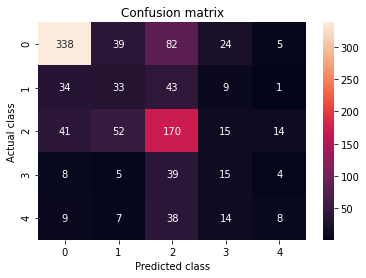

In [217]:
print ('Classification Report : \n', classification_report(y_test.astype('int'), y_pred_class))
sns.heatmap(confusion_matrix(y_test.astype('int'), y_pred_class), annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

In [225]:
print('''-----------------------------------------------------------------------------------------------------------------------
| Layers                                        | Test Accuracy            | Test Kappa score  |  Test Macro-F1 score
-----------------------------------------------------------------------------------------------------------------------''')
print("| VGG16 without Top & CNN as FC                 | 0.72                     | 0.79              | 0.53")
print('''-----------------------------------------------------------------------------------------------------------------------''')
print("| DenseNet                                      | 0.53                     | 0.49              | 0.37")
print('''-----------------------------------------------------------------------------------------------------------------------''')

-----------------------------------------------------------------------------------------------------------------------
| Layers                                        | Test Accuracy            | Test Kappa score  |  Test Macro-F1 score
-----------------------------------------------------------------------------------------------------------------------
| VGG16 without Top & CNN as FC                 | 0.72                     | 0.79              | 0.53
-----------------------------------------------------------------------------------------------------------------------
| DenseNet                                      | 0.53                     | 0.49              | 0.37
-----------------------------------------------------------------------------------------------------------------------


**Observation:**

* VGG16-CNN model is getting overfit from the 30th epoch, and there is no improvement in accuracy and loss. We achieved 72 % accuracy on test data.

* DenseNet model is getting overfit after few epochs itself. At end of the 100th epoch it reaches a very good accuracy ~ 95 % on training data, but there is no improvement in test accuracy, and it didn't improve from ~65 %

* I have tried with different growth rate with different depths, and many augumentation techniques, and different learning rates with One cycle LR, but none of them produced good results. All of them overfit well.